In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

# Pretty display for notebooks
import matplotlib.pyplot as plt
%matplotlib inline

# Load the Porto training dataset
data = pd.read_csv('creditcard.csv')

# Success
print "This dataset has {} data points with {} variables each.".format(*data.shape)

y=data['Class']
X=data.drop(['Class','Time'],axis = 1) #drop time class since the fraud transactions are not connected

print X.shape
print y.shape

data.info() #identify if there are any null values
data.keys() #identify the columns

percent_fraud = 100*float(np.sum(y))/len(X)
print "{0:0.4f} % of the dataset are fraudulent transactions".format(percent_fraud)

This dataset has 284807 data points with 31 variables each.
(284807, 29)
(284807,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-nul

In [2]:
# pre-process the data to make it usable
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X = scaler.fit_transform(X)
print X.shape
print y.shape

(284807, 29)
(284807,)


##Visualization and Exploration

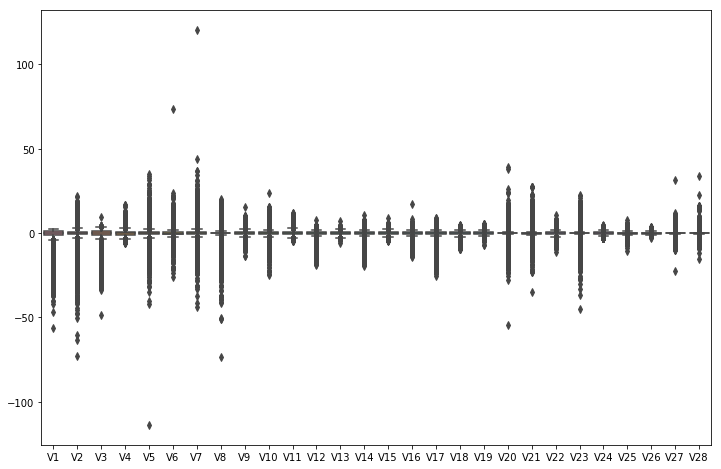

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
sns.boxplot(data=X.drop('Amount',axis=1),hue='Class')

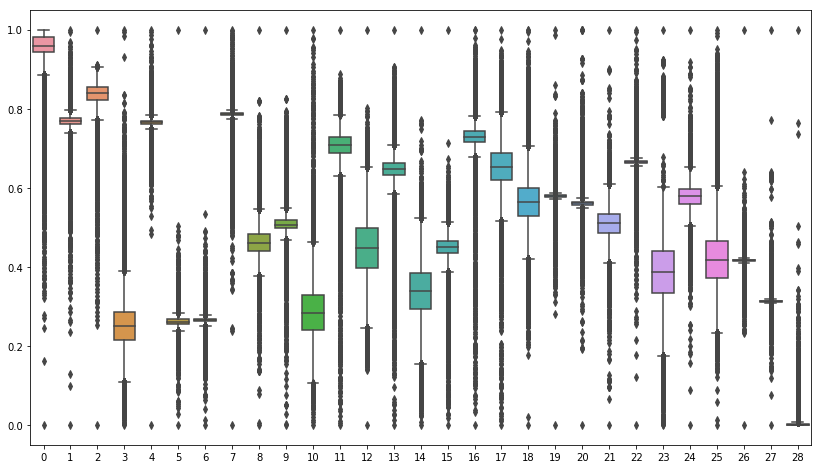

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,8))
sns.boxplot(data=X,hue="Class")

/Applications/anaconda3/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


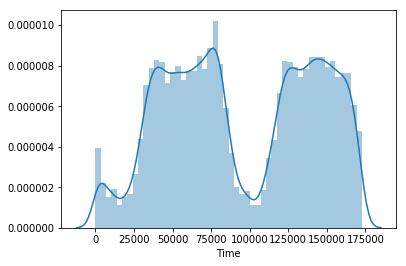

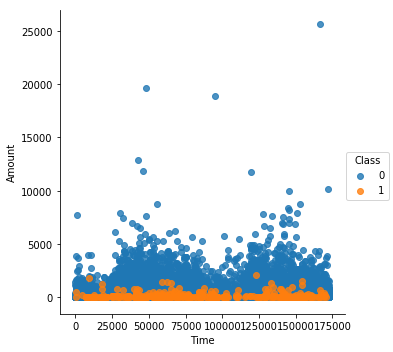

In [183]:
sns.distplot(data.Time)
sns.lmplot(x='Time', y='Amount', data=data,fit_reg=False,hue='Class')

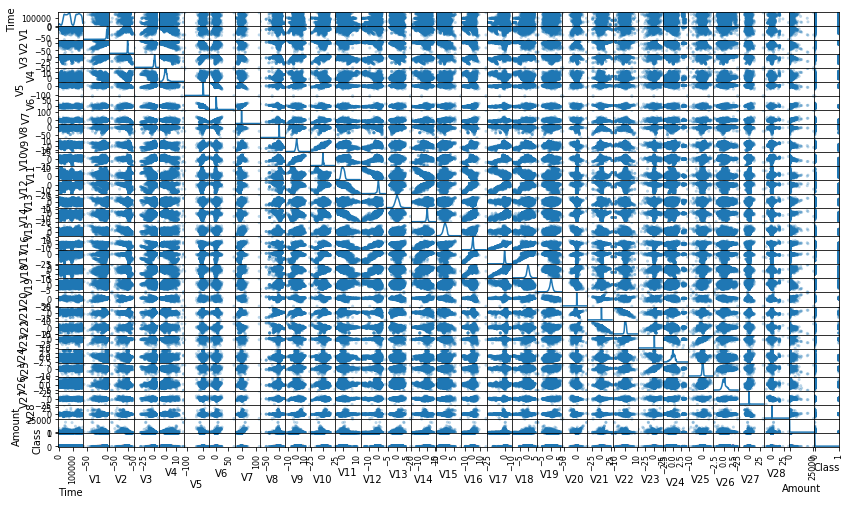

In [15]:
# correlation between features
plt.figure(figsize=(20,16))
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

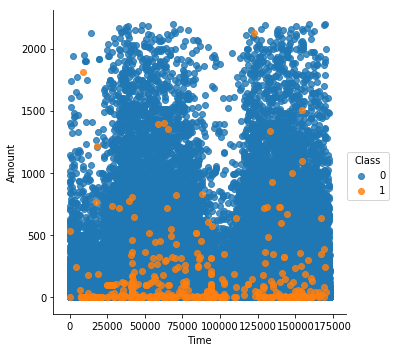

In [181]:
amount_class_df=data[['Amount','Time','Class']].loc[data['Amount']<2200.]
sns.lmplot(x='Time', y='Amount', data=amount_class_df,fit_reg=False,hue='Class')
#sns.lmplot(x='Time', y='V1', data=data,fit_reg=False,hue='Class')

There is no fraud for amounts greater than about $ 2,300.

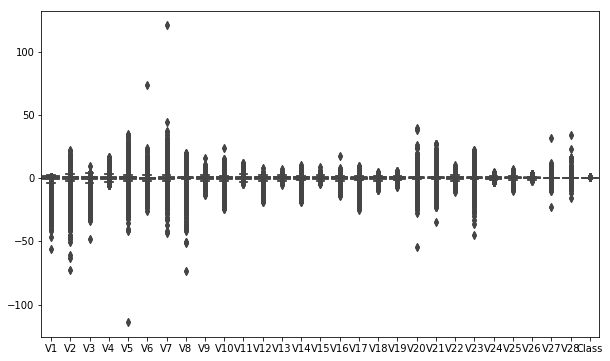

In [18]:
#violin plot for V1 to V28
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
feature_data=data.drop(['Amount','Time'],axis=1)
sns.boxplot(data=feature_data)
scaled_feature_data=scaler.fit_transform(feature_data)
sns.boxplot(data=scaled_feature_data)
sns.boxplot(data=feature_data)

sns.set_style('whitegrid')
sns.violinplot(x='Type 1', y='Class', data=df)

## Define Helper Functions
##Apply Classifiers to the dataset

In [66]:
# Report the prediction scores and plot precision recall curve for various classifiers
from sklearn.metrics import average_precision_score,recall_score,precision_recall_curve,\
roc_curve,auc,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,StratifiedKFold
from scipy import interp
import itertools
import matplotlib.pyplot as plt


def draw_performance_curves(clf_name,classifier,X,y,sample_weight,n_folds=6):
    
    #note that sample weights are the transaction amounts
    
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)

    ## Initialize vars for ROC Curve
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
 
    cv = StratifiedKFold(n_splits=n_folds)
    for i,(train, test) in enumerate(cv.split(X,y)):
        classifier.fit(X[train], y[train],sample_weight=np.array(sample_weight[train]))
        probas_ = classifier.predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clf_name + ' Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    
    ##Code for Precision Recall Curve
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,2)

    mean_av_precision=0.
    mean_rec_score=0.    
    cv=StratifiedKFold(n_splits=n_folds)
    total_fn_loss =0.
    total_fp_loss=0.
    mean_total_fn_loss = 0.
    mean_total_fp_loss = 0.
    
    for i,(train,test) in enumerate(cv.split(X,y)):
        
        classifier.fit(X[train],y[train],sample_weight=np.array(sample_weight[train]))
        y_probas_ = classifier.predict_proba(X[test])
        y_pred=classifier.predict(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], y_probas_[:, 1],pos_label=1)
        av_precision=average_precision_score(y[test], y_pred)
        rec_score=recall_score(y[test],y_pred)
        plt.plot(recall, precision, lw=1, label="PR fold {fold:1d} AP = {ap:0.4f} Recall = {rs:0.4f}".
                 format(fold=i,ap=av_precision,rs=rec_score)) 
        mean_av_precision+=av_precision
        mean_rec_score+=rec_score

        #Cost of False Negative
        total_fn_loss += np.sum(sample_weight[np.logical_and(y[test] == 1, y_pred == 0)]) 
        #Cost of False Positive assumed to be 50% of amount
        total_fp_loss += 0.5 * np.sum(sample_weight[np.logical_and(y[test] == 0, y_pred == 1)])
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.0, 1.0])

    mean_av_precision/=n_folds
    mean_rec_score/=n_folds

    mean_total_fn_loss/=n_folds
    mean_total_fp_loss/=n_folds
    mean_total_cost = mean_total_fn_loss + mean_total_fp_loss
    
    title = clf_name + \
    (' Prec-Rec Mean AP= {mean_av_p:0.3f} Mean Recall = {mean_rec_s:0.3f} \
    Error Cost {mean_total_c:.3f}').format(mean_av_p=mean_av_precision,mean_rec_s=mean_rec_score,\
                                              mean_total_c = mean_total_cost)
    plt.legend(loc="lower right")
    plt.title(title)
    plt.show()
    
    print "Average total_fn_loss = $ {:0.2f}".format(mean_total_fn_loss)
    print "Average total_fp_loss = $ {:0.2f}".format(mean_total_fp_loss)
    print "Average total cost of error = $ {:0.2f}".format(mean_total_cost)

    
def feature_importance_graph(trained_clf):
    importances = trained_clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True)
    importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')
    
def output_classifier_score(clf_name,y_test,y_pred,y_pred_proba,amount):
    print clf_name
    average_precision = average_precision_score(y_test, y_pred_proba[:, 1])
    print "Average Precision = {0:0.4f} Recall Score = {0:0.4f}".format(
        average_precision,recall_score(y_test,y_pred))
    target_names=['Legit','Fraud']
    print classification_report(y_test, y_pred, target_names=target_names,digits=4)

    #plot confusion matrix
    plt.figure(figsize=(10,6))

    cm=confusion_matrix(y_test,y_pred)
    #print amount[np.logical_and(y_test == 1, y_pred == 0)]
    
    #Cost of False Negative
    total_fn_loss= np.sum(amount[np.logical_and(y_test == 1, y_pred == 0)]) 

    #Cost of False Positive
    total_fp_loss=0.5 * np.sum(amount[np.logical_and(y_test == 0, y_pred == 1)])
    
    print "Total_fn_loss = $ {:0.2f}".format(total_fn_loss)
    print "Total_fp_loss = $ {:0.2f}".format(total_fp_loss)
    print "Total cost of error = $ {:0.2f}".format(total_fn_loss + total_fp_loss)
    
    cmap=plt.cm.Blues
    classes = ['Legit','Fraud']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

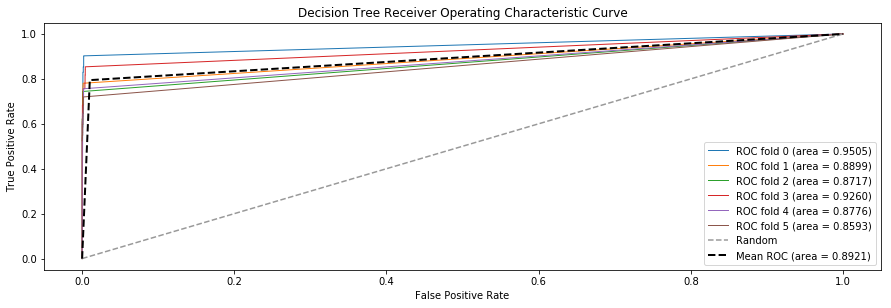

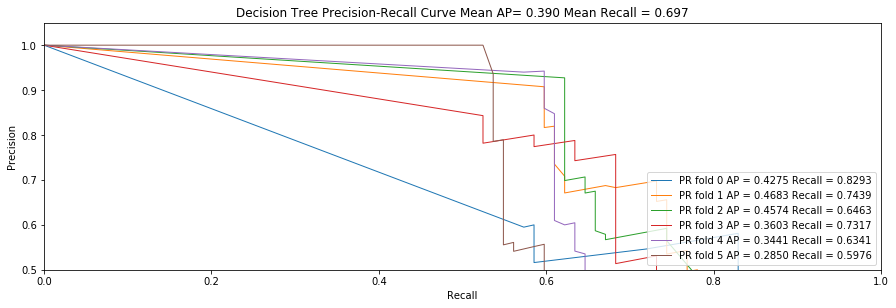

Decision Tree Classifier
Average Precision = 0.8070 Recall Score = 0.8070
             precision    recall  f1-score   support

      Legit     0.9996    0.9998    0.9997     56864
      Fraud     0.8750    0.7857    0.8280        98

avg / total     0.9994    0.9994    0.9994     56962

3228        1.00
4178       76.02
8379       70.48
10279      67.46
11245      11.85
17388     835.00
22412       1.29
22797      72.15
31575      25.80
33127       5.70
36677     122.00
36918     110.25
37841     132.71
40663    1327.17
43088       7.40
48678     104.45
48954      29.65
50442       5.00
51016      48.79
55764     325.15
56467      69.99
Name: Amount, dtype: float64
total_fn_loss =  3449.31
total_fp_loss =  69.325


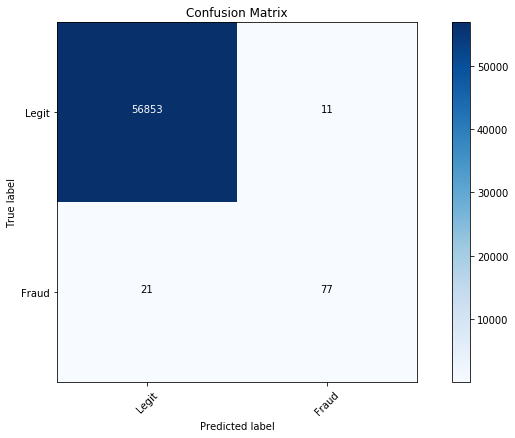

In [61]:
#use sample weight parameter for cost sensitive learning
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
dectree_clf = DecisionTreeClassifier(min_samples_leaf=5,random_state=42) # avoid overfitting

transaction_amount = data['Amount']

draw_performance_curves('Decision Tree',dectree_clf,X,y,transaction_amount)
plt.show()

dectree_clf.fit(X_train,y_train)
y_pred=dectree_clf.predict(X_test)
y_pred_proba=dectree_clf.predict_proba(X_test)

output_classifier_score("Decision Tree Classifier",y_test,y_pred,y_pred_proba,transaction_amount)

Average total_fn_loss = $ 0.00
Average total_fp_loss = $ 0.00
Average total cost of error = $ 0.00


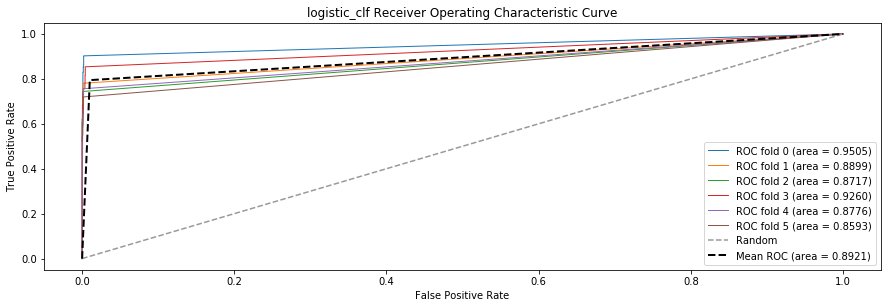

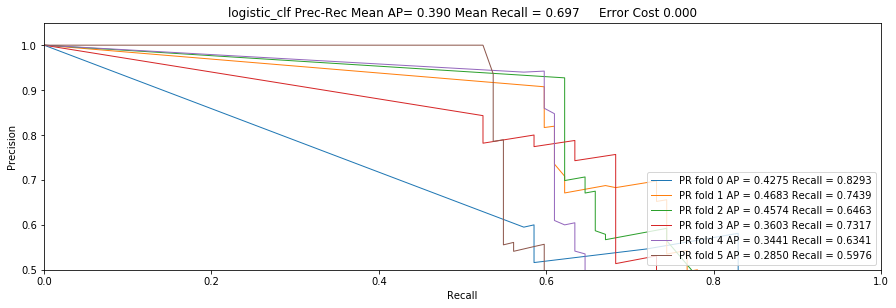

logistic_clf
Average Precision = 0.8273 Recall Score = 0.8273
             precision    recall  f1-score   support

      Legit     0.9997    0.9982    0.9990     56864
      Fraud     0.4486    0.8469    0.5866        98

avg / total     0.9988    0.9979    0.9983     56962

Total_fn_loss = $ 2915.84
Total_fp_loss = $ 6681.13
Total cost of error = $ 9596.97


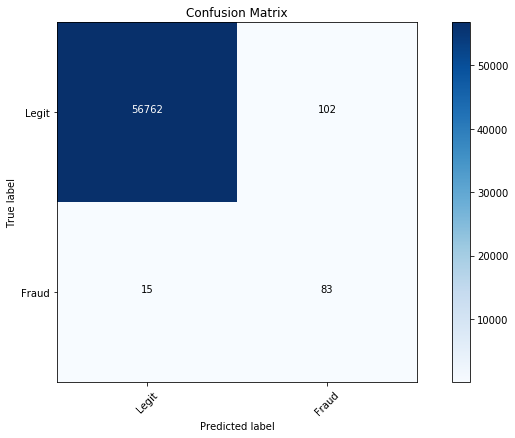

Average total_fn_loss = $ 0.00
Average total_fp_loss = $ 0.00
Average total cost of error = $ 0.00


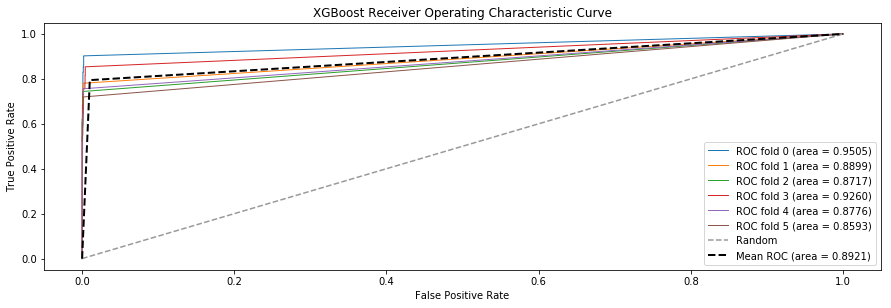

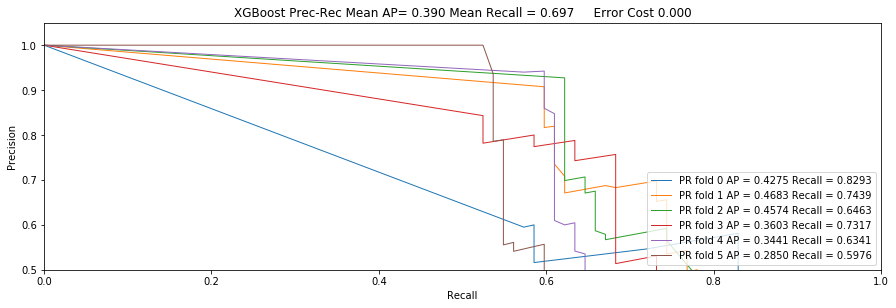

XGBoost
Average Precision = 0.8273 Recall Score = 0.8273
             precision    recall  f1-score   support

      Legit     0.9997    0.9982    0.9990     56864
      Fraud     0.4486    0.8469    0.5866        98

avg / total     0.9988    0.9979    0.9983     56962

Total_fn_loss = $ 2915.84
Total_fp_loss = $ 6681.13
Total cost of error = $ 9596.97


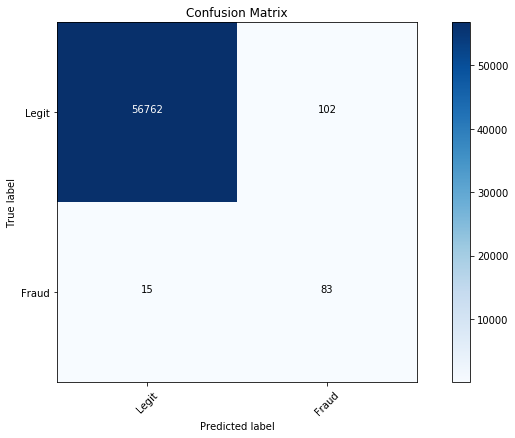

Average total_fn_loss = $ 0.00
Average total_fp_loss = $ 0.00
Average total cost of error = $ 0.00


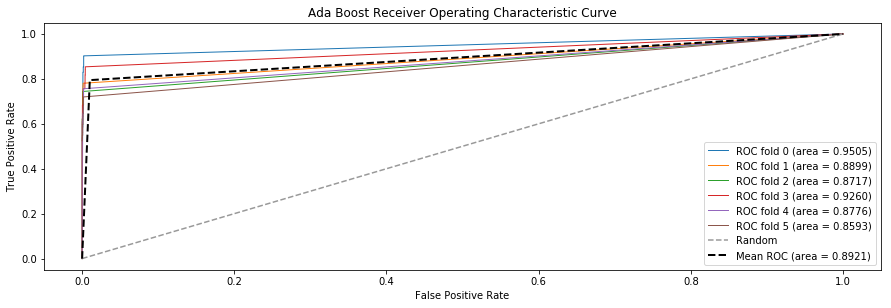

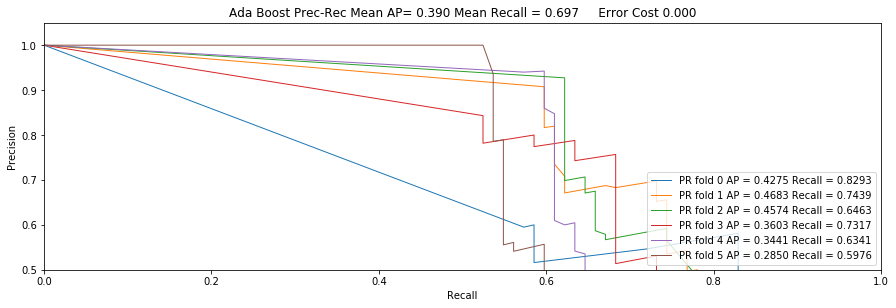

Ada Boost
Average Precision = 0.8273 Recall Score = 0.8273
             precision    recall  f1-score   support

      Legit     0.9997    0.9982    0.9990     56864
      Fraud     0.4486    0.8469    0.5866        98

avg / total     0.9988    0.9979    0.9983     56962

Total_fn_loss = $ 2915.84
Total_fp_loss = $ 6681.13
Total cost of error = $ 9596.97


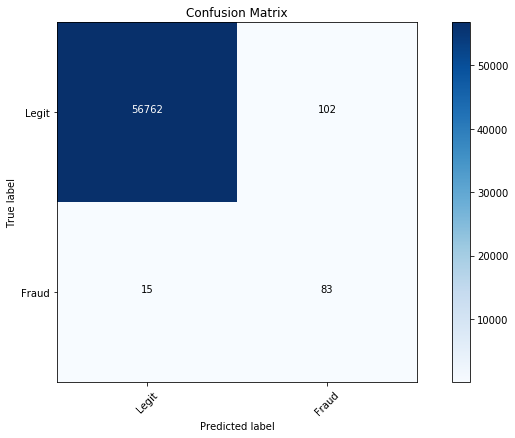

In [ ]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
rand_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

from sklearn.tree import DecisionTreeClassifier
dectree_clf = DecisionTreeClassifier(min_samples_leaf=5,random_state=42) # min_samples_leaf to avoid overfitting

from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression()

import xgboost as xgb
xgboost_clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

classifiers= {'logistic_clf': logistic_clf,'Decision Tree':dectree_clf, 'Random Forest':rand_clf,
              'Ada Boost':ada_clf,'XGBoost':xgboost_clf}

for clf_name,clf in classifiers.items():
    draw_performance_curves(clf_name,dectree_clf,X,y,transaction_amount)
    clf.fit(X_train,y_train)
    y_pred=dectree_clf.predict(X_test)
    y_pred_proba=dectree_clf.predict_proba(X_test)
    output_classifier_score(clf_name,y_test,y_pred,y_pred_proba,transaction_amount)

In [159]:
import pickle
pickle.dump(xgboost_clf, open("xgboost.pickle.dat", "wb"))

Since XGBoost performs the best of all the classifiers, we will use this for further exploration. At this point, there are two approaches. The first is to explore data-based methods to improve the balance of the underlying dataset and see if that performs better. The second is to tune hyper-parameters of XGBoost.

In [105]:
# Explore data-based methods
from imblearn.over_sampling import RandomOverSampler
OverSampler=RandomOverSampler(random_state=42)
X_over,y_over = OverSampler.fit_sample(X, y)

from imblearn.under_sampling import RandomUnderSampler,NearMiss
UnderSampler=RandomUnderSampler(random_state=42)
X_under,y_under = UnderSampler.fit_sample(X, y)

NearMissSampler=NearMiss(random_state=42)
X_nearmiss,y_nearmiss = NearMissSampler.fit_sample(X, y)

from imblearn.combine import SMOTEENN
SMOTESampler=SMOTEENN(random_state=42)
X_smote,y_smote = SMOTESampler.fit_sample(X, y)

SMOTE ENN
Average Precision = 0.9955 Recall Score = 0.9955
             precision    recall  f1-score   support

         OK     0.8520    1.0000    0.9201     71030
      Fraud     1.0000    0.8263    0.9049     71027

avg / total     0.9260    0.9132    0.9125    142057



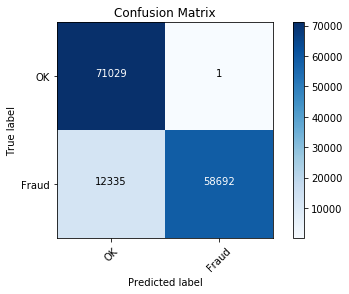

In [121]:
import pickle

from sklearn.model_selection import train_test_split

xgboost_clf = pickle.load(open("xgboost.pickle.dat", "rb"))

#for sampler_name,X,y in [('OverSampler',X_over,y_over),
#                         ('UnderSampler',X_under,y_under),
#                         ('NearMiss',X_nearmiss,y_nearmiss),
#                        ('SMOTE ENN',X_smote,y_smote)]:

for sampler_name,X,y in [('SMOTE ENN',X_smote,y_smote)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    y_pred = xgboost_clf.predict(X_test)
    y_pred_proba = xgboost_clf.predict_proba(X_test)
    output_classifier_score(sampler_name,y_test,y_pred,y_pred_proba)

Oversampling and the SMOTE method of sampling performs best. SMOTE is a mix of both under and oversampling. Now, we will tune hyper parameters for XGBoost to improve the AUC and recall scores.

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 300, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter=8)
optimized_GBM.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [10]:
optimized_GBM.cv_results_

{'mean_fit_time': array([  145.41872845,  2450.7132237 ,   159.90643997,   122.75398078,
           86.49034739,    82.06357098,   128.06235576,   121.28832679]),
 'mean_score_time': array([ 0.60759292,  0.63611417,  0.38244042,  0.52046714,  0.3949842 ,
         0.3864171 ,  0.49506216,  0.53755603]),
 'mean_test_score': array([ 0.97920916,  0.97840549,  0.97847301,  0.97844255,  0.97959824,
         0.97979172,  0.97886214,  0.97844442]),
 'mean_train_score': array([ 1.        ,  1.        ,  0.99999237,  1.        ,  0.99997206,
         0.99999925,  0.99999877,  1.        ]),
 'param_max_depth': masked_array(data = [7 5 3 7 3 3 7 5],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 1 3 3 5 1 5 3],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 7, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 1}

In [12]:
beta=0.9
y_pred = optimized_GBM.predict(X_test)
classifier_scoring('XG Boost',y_test,y_pred,beta)

XG Boost
fbeta_score = 0.8833 AUC = 0.8833 Mathews Coeff = 0.8833
             precision    recall  f1-score   support

         OK     0.9997    0.9999    0.9998     71089
      Fraud     0.9485    0.8142    0.8762       113

avg / total     0.9996    0.9996    0.9996     71202



In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'learning_rate': [0.2, 0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 400, 'random_state':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter = 8)
optimized_GBM.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'subsample': [0.7, 0.8, 0.9], 'learning_rate': [0.2, 0.1, 0.01]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [4]:
optimized_GBM.cv_results_

{'mean_fit_time': array([  92.46438961,  269.06298442,  117.03574986,   91.88121352,
         309.93403873,  116.53746047,  107.90348182,   99.67870159]),
 'mean_score_time': array([ 0.53948917,  0.64924178,  0.6487627 ,  0.54248633,  0.62518868,
         0.40660119,  0.40386653,  0.40269303]),
 'mean_test_score': array([ 0.97868338,  0.97533936,  0.97581373,  0.97743899,  0.97924625,
         0.95208869,  0.96142721,  0.95750518]),
 'mean_train_score': array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         0.97188597,  0.97150987,  0.97254323]),
 'param_learning_rate': masked_array(data = [0.1 0.2 0.2 0.2 0.1 0.01 0.01 0.01],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_subsample': masked_array(data = [0.7 0.7 0.8 0.9 0.8 0.9 0.7 0.8],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': [{'learning_rate': 0.1, 'subsample': 0.7},
  {'learning_rat

In [6]:
xgdmat = xgb.DMatrix(X_train, y_train)

In [7]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.7, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Randomized Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['auc'],
                early_stopping_rounds = 100) 
# Look for early stopping that minimizes error

In [8]:
cv_xgb.tail(10)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
145,0.982550,0.008811,0.999570,0.000069
146,0.982771,0.008591,0.999585,0.000071
147,0.983224,0.008536,0.999594,0.000078
148,0.983119,0.008547,0.999601,0.000087
149,0.983007,0.008666,0.999615,0.000087
150,0.983048,0.008684,0.999624,0.000091
151,0.983099,0.008502,0.999642,0.000088
152,0.983208,0.008259,0.999648,0.000092
153,0.983380,0.008212,0.999674,0.000077
154,0.983509,0.008455,0.999689,0.000073


In [9]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.9, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1}
final_gb = xgb.train(our_params, xgdmat, num_boost_round = 154)

In [172]:
import pickle
pickle.dump(xgboost_clf, open("xgboost.pickle.dat", "wb"))

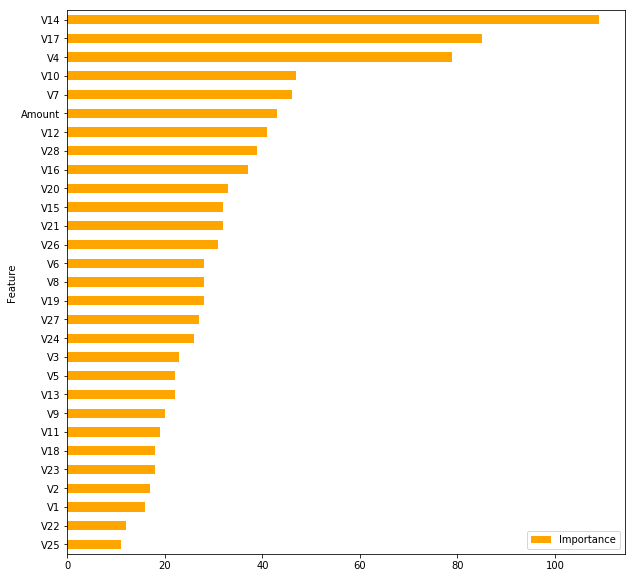

In [12]:
feature_importance_graph(final_gb)

In [13]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')

NameError: name 'importances' is not defined

In [ ]:
from sklearn.metrics.scorer import make_scorer

def weighted_cost_scorer(X, y_pred,y_true):
    cost=abs(y_pred-y_true)*X['Amount']
    return cost

weighted_scorer = make_scorer(weighted_cost_scorer, greater_is_better=False)

In [62]:
# intermediate code to find highest value of amounts tagged as fraud
high_fraud_amounts = data.loc[data['Class']==1].sort_values(by=['Amount'],ascending=False)
high_fraud_amounts = high_fraud_amounts['Amount']
display(high_fraud_amounts.head())

176049    2125.87
6971      1809.68
249167    1504.93
89190     1402.16
81609     1389.56
Name: Amount, dtype: float64

In [176]:
testdmat = xgb.DMatrix(X_test)
y_pred_proba = final_gb.predict(testdmat)
y_pred[y_pred_proba > 0.5] = 1
y_pred[y_pred_proba <= 0.5] = 0
beta=0.9
classifier_scoring('Tuned XG Boost',y_test,y_pred,beta)
print confusion_matrix(y_pred,y_test)

Tuned XG Boost
fbeta_score = 0.9997 AUC = 0.9997 Mathews Coeff = 0.9997
             precision    recall  f1-score   support

         OK     1.0000    0.9995    0.9997     71030
      Fraud     0.9995    1.0000    0.9997     71027

avg / total     0.9997    0.9997    0.9997    142057

[[70994     0]
 [   36 71027]]


In [17]:
# Exploring cost-sensitive methods
# Create another feature by multiplying amount by the class
amount=data['Amount']
fraud=data['Class']
y = amount*fraud
X= data.drop(['Class','Time','Amount'],axis=1)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rand_clf = RandomForestRegressor(random_state=42)
rand_clf.fit(X_train,y_train)
rand_y_pred= rand_clf.predict(X_test)

threshold = 10.
rand_y_pred[rand_y_pred > threshold] = 1
rand_y_pred[rand_y_pred <= threshold] = 0

In [36]:
print rand_y_pred>0.
beta=0.9
classifier_scoring('Modified Classifier using RandomForestRegressor',y_test,rand_y_pred,beta)

[False False False ..., False False False]
Modified Classifier using RandomForestRegressor
fbeta_score = 0.0000 AUC = 0.0000 Mathews Coeff = 0.0000
             precision    recall  f1-score   support

         OK     0.9984    1.0000    0.9992     71089
      Fraud     0.0000    0.0000    0.0000       113

avg / total     0.9968    0.9984    0.9976     71202



In [ ]:
# Split the data into training and testing sets using the given feature as the target
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a classifier and fit it to the training set
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
rand_clf = RandomForestClassifier(random_state=42)
rand_clf.fit(X_train,y_train)
rand_y_pred= rand_clf.predict(X_test)
rand_y_pred_proba = rand_clf.predict_proba(X_test)

ada_clf = AdaBoostClassifier(random_state=42)
ada_clf.fit(X_train,y_train)
ada_y_pred= ada_clf.predict(X_test)
ada_y_pred_proba= ada_clf.predict_proba(X_test)

from sklearn.tree import DecisionTreeClassifier
dectree_clf = DecisionTreeClassifier(min_samples_leaf=10,random_state=42) # avoid overfitting
dectree_clf.fit(X_train,y_train)
dectree_y_pred= dectree_clf.predict(X_test)
dectree_y_pred_proba= dectree_clf.predict_proba(X_test)

from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB()
nb_clf.fit(X_train,y_train)
nb_y_pred= nb_clf.predict(X_test)
nb_y_pred_proba= nb_clf.predict_proba(X_test)

import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
xgboost_y_pred = gbm.predict(X_test)
xgboost_y_pred_proba = gbm.predict_proba(X_test)

In [ ]:
def draw_precision_recall(clf_name,clf,X,y,fig_num=1,n_folds=6,use_sample_weight=False):
    i=0
    mean_av_precision=0.
    mean_rec_score=0.
    
    plt.figure(fig_num)
    plt.figure(figsize=(10,6))

    cv=StratifiedKFold(n_splits=n_folds)
    print "Length of X =",X.shape
    print "Length of y =",y.shape
    
    for i,(train,test) in enumerate(cv.split(X,y)):
        if use_sample_weight:
            sample_weight=X['Amount']
            #print "Length of sample weight", len(sample_weight)
            #print "train", train
            #sample_weight_train=sample_weight[train]
            #print "Sample weight train", sample_weight_train
            #print "X[train]=", X[train]
            clf.fit(X[train],y[train])
        else:
            clf.fit(X[train],y[train])            



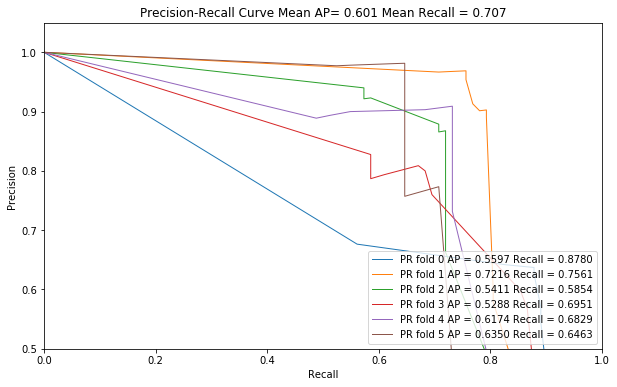

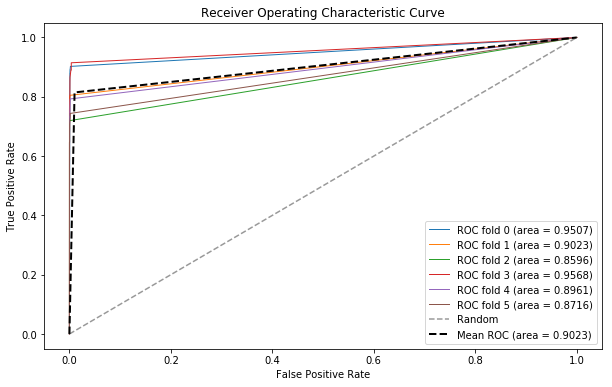

In [148]:
from sklearn.tree import DecisionTreeClassifier
dectree_clf = DecisionTreeClassifier(min_samples_leaf=5,random_state=42)
draw_precision_recall(dectree_clf,X,y,1)
draw_roc_curve(dectree_clf,X,y,2)
plt.show()

In [147]:
# Report the prediction scores and plot precision recall curve for various classifiers
from sklearn.metrics import average_precision_score,recall_score,precision_recall_curve,\
roc_curve,auc,classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import itertools

def draw_precision_recall(clf_name,clf,X,y,sample_weight=None,fig_position=1,n_folds=6):
    i=0
    mean_av_precision=0.
    mean_rec_score=0.
    
    plt.figure(fig_position)
    plt.figure(figsize=(10,6))

    cv=StratifiedKFold(n_splits=n_folds)
    print "Length of X =",X.shape
    print "Length of y =",y.shape
    
    for i,(train,test) in enumerate(cv.split(X,y)):
        clf.fit(X[train],y[train],sample_weight=np.array(sample_weight[train]))
        y_probas_ = clf.predict_proba(X[test])
        y_pred=clf.predict(X[test])
        precision, recall, thresholds = precision_recall_curve(y[test], y_probas_[:, 1],pos_label=1)
        av_precision=average_precision_score(y[test], y_pred)
        rec_score=recall_score(y[test],y_pred)
        plt.plot(recall, precision, lw=1, label="PR fold {fold:1d} AP = {ap:0.4f} Recall = {rs:0.4f}".
                 format(fold=i,ap=av_precision,rs=rec_score)) 
        mean_av_precision+=av_precision
        mean_rec_score+=rec_score
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.0, 1.0])
    mean_av_precision/=n_folds
    mean_rec_score/=n_folds
    title = clf_name + (' Precision-Recall Curve Mean AP= {mean_av_p:0.3f} Mean Recall = {mean_rec_s:0.3f}').\
    format(mean_av_p=mean_av_precision,mean_rec_s=mean_rec_score)
    plt.legend(loc="lower right")
    plt.title(title)
    return clf # returning trained classifier
    
def draw_roc_curve(clf_name,classifier,X,y,fig_position=2,n_folds=6,pos_label=1):
    
    ax = plt.subplot(fig_position)
    ax.figure(figsize=(10,6))
    
    # Compute ROC curve and area for the curve
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    cv = StratifiedKFold(n_splits=n_folds)
    for i,(train, test) in enumerate(cv.split(X,y)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    ax.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    ax.xlim([-0.05, 1.05])
    ax.ylim([-0.05, 1.05])
    ax.xlabel('False Positive Rate')
    ax.ylabel('True Positive Rate')
    ax.title(clf_name + ' Receiver Operating Characteristic Curve')
    ax.legend(loc="lower right")
    
def feature_importance_graph(trained_clf):
    importances = trained_clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True)
    importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')
    
def output_classifier_score(clf_name,y_test,y_pred,y_pred_proba):
    print clf_name
    average_precision = average_precision_score(y_test, y_pred_proba[:, 1])
    print "Average Precision = {0:0.4f} Recall Score = {0:0.4f}".format(
        average_precision,recall_score(y_test,y_pred))
    target_names=['Legit','Fraud']
    print classification_report(y_test, y_pred, target_names=target_names,digits=4)

def show_confusion_matrix(y_test,y_pred,fig_position=1):
    #plot confusion matrix - code from sklearn documentation
    ax = plt.subplot(fig_position)
    cm=confusion_matrix(y_test,y_pred)
    cmap=plt.cm.Blues
    classes = ['Legit','Fraud']
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.title("Confusion Matrix")
    ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.xticks(tick_marks, classes, rotation=45)
    ax.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.tight_layout()
    ax.ylabel('True label')
    ax.xlabel('Predicted label')